In [ ]:
import os, re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install transformers tika

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.2 MB/s eta 0:00:00
  Created wheel for tika: filename=tika-2.6.0-py3-none-any.whl size=32641 sha256=9de45aa0cdcdd140f0bdffdce0c1dc5b3e72ec5c97ba8ec6d431592c553a7385
  Stored in directory: /root/.cache/pip/wheels/13/56/18/e752060632d32c39c9c4545e756dad281f8504dafcfac02b95
Successfully built tika


In [ ]:
from transformers import BertTokenizer, TFBertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

model.summary()

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "tf_bert_for_masked_lm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  24459834  
                                                                 
Total params: 109,514,298
Trainable params: 109,514,298
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/CYsyphus/indexed_corpus

/content/drive/.shortcut-targets-by-id/1X1APgHBDiD-6ucORNx5eM_SWKZYOgyvz/indexed_corpus


In [ ]:
def remove_punc(pdf_content):
    punc = ['• ', '· ', '&', '~', ' o ', '\uf0a7', '\uf03c', '\uf0b7', 
            '–', '()', '[…]', '| ', '© ', '(Insert Scale)', '_', '%', '[', ']', 'Ü ']
    for p in punc:
        pdf_content = pdf_content.replace(p, '')
    return pdf_content

def remove_bulleted_points(pdf_content):
    pdf_content = re.sub(r'\.+ [0-9]+', '.', pdf_content)
    pdf_content = re.sub(r'\.+[0-9]+', '.', pdf_content)
    pdf_content = re.sub(r'\.+', '.', pdf_content)

    pdf_content = re.sub(r'\([0-9]+\)', '', pdf_content)
    pdf_content = re.sub(r'[0-9]+\)', '', pdf_content)
    pdf_content = re.sub(r'[0-9]+.', '', pdf_content)
    pdf_content = re.sub(r'\([a-zA-Z]\)', '', pdf_content)
    pdf_content = re.sub(r' [a-zA-Z]\)', '', pdf_content)
    pdf_content = re.sub(r'\(i+\)', '', pdf_content)
    pdf_content = re.sub(r' i+\)', '', pdf_content)

    pdf_content = re.sub('\s\s+', ' ', pdf_content)
    return pdf_content

def remove_url(pdf_content):
    url = re.findall('http[s]?://\S+', pdf_content)
    for u in url:
        pdf_content = pdf_content.replace(u, '')
    url = re.findall('www.\S+', pdf_content)
    for u in url:
        pdf_content = pdf_content.replace(u, '')
    pdf_content = re.sub(r'http[s]?://', '', pdf_content)
    return pdf_content

def filter_sentences_by_length(pdf_sentence):
    return [s for s in pdf_sentence if len(word_tokenize(s)) > 4 and len(word_tokenize(s)) < 200]

In [ ]:
from tika import parser

sentences = []

for i in range(1, 16):
    
    pdf_path = str(i) + ".pdf"
    parsed_pdf = parser.from_file(pdf_path)

    pdf_content = parsed_pdf['content'].replace('\n', ' ').replace(';', '.').strip()
    pdf_content = remove_punc(pdf_content)
    pdf_content = remove_bulleted_points(pdf_content)
    pdf_content = remove_url(pdf_content)
    pdf_content = remove_punc(pdf_content)
    pdf_content = re.sub(r'\.+', '.', pdf_content)
    pdf_content = re.sub(r'\s\s+', ' ', pdf_content)
    
    pdf_sentence = sent_tokenize(pdf_content)
    filtered_sentence = filter_sentences_by_length(pdf_sentence)
    sentences += filtered_sentence

len(sentences)

13667

In [ ]:
inputs = tokenizer(
    sentences, 
    max_length=100, 
    truncation=True, 
    padding='max_length', 
    return_tensors='tf'
)

inputs['labels'] = inputs['input_ids']
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [ ]:
import numpy as np

inp_ids = []

for inp in inputs.input_ids.numpy():
    actual_tokens = list(set(range(len(inp))) - set(np.where((inp == 101) | (inp == 102) | (inp == 0))[0].tolist()))
        
    # Select 15% random tokens from the given list
    num_of_token_to_mask = max(1, int(len(actual_tokens) * 0.15))
    token_to_mask = np.random.choice(np.array(actual_tokens), size=num_of_token_to_mask, replace=False).tolist()
    
    # Now we have the indices where we need to mask the tokens
    inp[token_to_mask] = 103
    inp_ids.append(inp)

inputs['input_ids'] = tf.convert_to_tensor(np.asarray(inp_ids))

In [ ]:
split_ratio = 0.2
data_size = len(inputs['input_ids'])
val_size = int(split_ratio * data_size)
train_size = data_size - val_size

arr = np.arange(data_size)
val_indices = np.random.choice(arr, size=val_size, replace=False)
train_indices = np.delete(arr, val_indices)

val_indices, train_indices = tf.convert_to_tensor(val_indices), tf.convert_to_tensor(train_indices)

In [ ]:
train_input_ids = tf.convert_to_tensor(np.array(inputs.input_ids)[train_indices])
train_attention_mask = tf.convert_to_tensor(np.array(inputs.attention_mask)[train_indices])
train_labels = tf.convert_to_tensor(np.array(inputs.labels)[train_indices])

val_input_ids = tf.convert_to_tensor(np.array(inputs.input_ids)[val_indices])
val_attention_mask = tf.convert_to_tensor(np.array(inputs.attention_mask)[val_indices])
val_labels = tf.convert_to_tensor(np.array(inputs.labels)[val_indices])

print("train inputs shape:", train_input_ids.shape)
print("val inputs shape:", val_input_ids.shape)
print("train labels shape:", train_labels.shape)
print("val labels shape:", val_labels.shape)

train inputs shape: (10934, 100)
val inputs shape: (2733, 100)
train labels shape: (10934, 100)
val labels shape: (2733, 100)


In [ ]:
epochs = 10
batch_size = 16

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    )

history = model.fit(
    [train_input_ids, train_attention_mask], 
    train_labels, 
    verbose=1, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=([val_input_ids, val_attention_mask], val_labels)
    )

Epoch 1/10
684/684 [==============================] - 384s 453ms/step - loss: 0.2175 - val_loss: 0.0952
Epoch 2/10
684/684 [==============================] - 322s 470ms/step - loss: 0.0692 - val_loss: 0.0981
Epoch 3/10
684/684 [==============================] - 322s 471ms/step - loss: 0.0366 - val_loss: 0.1093
Epoch 4/10
684/684 [==============================] - 307s 449ms/step - loss: 0.0174 - val_loss: 0.1155
Epoch 5/10
684/684 [==============================] - 321s 470ms/step - loss: 0.0100 - val_loss: 0.1204
Epoch 6/10
684/684 [==============================] - 323s 472ms/step - loss: 0.0087 - val_loss: 0.1265
Epoch 7/10
684/684 [==============================] - 322s 471ms/step - loss: 0.0083 - val_loss: 0.1303
Epoch 8/10
684/684 [==============================] - 322s 471ms/step - loss: 0.0075 - val_loss: 0.1328
Epoch 9/10
684/684 [==============================] - 322s 471ms/step - loss: 0.0098 - val_loss: 0.1368
Epoch 10/10
684/684 [==============================] - 322s 471m

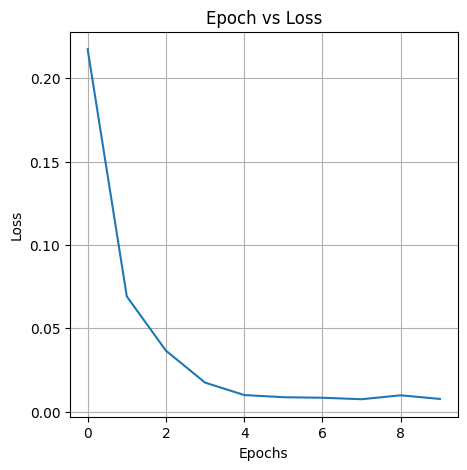

In [ ]:
# Train loss

losses = history.history['loss']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)), losses)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

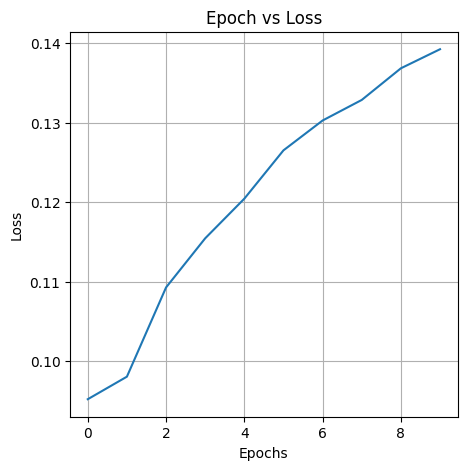

In [ ]:
# Val loss

losses = history.history['val_loss']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)), losses)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/fine_tuned_model_weights_traintestsplit.h5')

In [ ]:
input_ids = tokenizer("Hello, my dog is cute", return_tensors="tf")["input_ids"]
input_ids

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]],
      dtype=int32)>

In [ ]:
outputs = model(input_ids, labels=input_ids, output_hidden_states=True)
outputs[2][0].shape

TensorShape([1, 8, 768])